# Parte 1: Detecção de faces

Bibliotecas utilizadas.

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
import itertools
import pandas as pd
from keras import backend as K

Carregamento e conversão da imagem trabalhada.
A imagem carregada BGR é convertida para o padrão RGB.
Imagem RGB é convertida para escala de cinzas.

In [41]:
img = cv2.cvtColor(cv2.imread('data/cenario04.png'), cv2.COLOR_BGR2RGB)
img_temp = img.copy()

gray = cv2.cvtColor(img_temp, cv2.COLOR_RGB2GRAY)

Exibição das imagens original e em escala de cinzas.

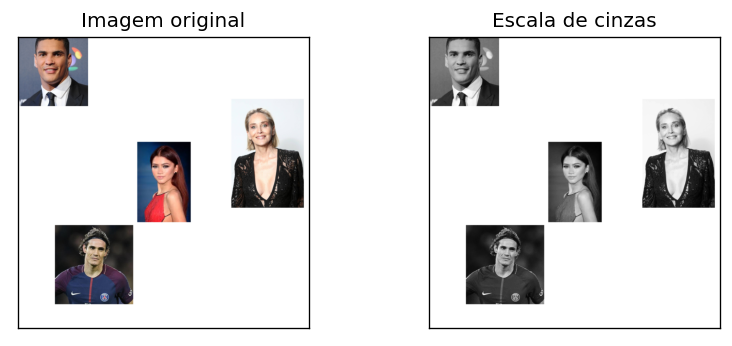

In [42]:
fig_luz, axes = plt.subplots(1,2,figsize=(7,3), dpi = 120)
plt.tight_layout()

for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
axes[0].imshow(img_temp)
axes[0].set_title('Imagem original')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Escala de cinzas')

plt.show()

Carregamento do arquivo .XML pré-treinado com as características haar para detecção de faces frontais.

In [43]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

Detecção das faces na imagem em escala de cinzas. O valor do fator de escala utilizado é 1,1 e o número mínimo de vizinhos é 9. É retornado os bounding boxes das possíveis faces detectadas.

In [ ]:
box = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 9)

Desenho dos retângulos das faces detectadas. Além disso, é obtido os pontos centrais das bounding boxes para posterior calculo da distâncias entre as faces detectadas.

In [45]:
cxy = np.zeros((box.shape[0], 2))

i = 0
for (x, y, w, h) in box:
    
    cx, cy = int(x+w/2), int(y+h/2)
    
    cxy[i,:] = (cx, cy)
    i+=1
    
    cv2.rectangle(img_temp, (x, y), (x+w, y+h), (0, 255, 0), 5)

In [46]:
print('Pontos centrais:')
print(cxy)

Pontos centrais:
[[826. 320.]
 [111.  79.]
 [489. 457.]
 [269. 739.]]


Exibição da imagem trabalhada com os bounding boxes das faces detectadas.

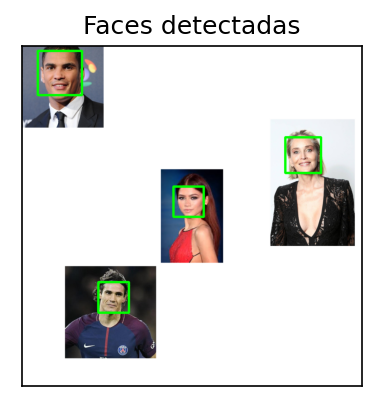

In [47]:
fig_luz, axes = plt.subplots(figsize=(7,3), dpi = 150)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

axes.imshow(img_temp)
axes.set_title('Faces detectadas')

plt.show()

# Parte 2: Classificação de faces

Rótulos das 8631 celebridades do dataset VGGFace.

In [48]:
labels = np.load('data/rcmalli_vggface_labels_v2.npy')

lDict = {'Label': labels}

labelsDF = pd.DataFrame(lDict)
labelsDF.head()

,Label
0,A_Fine_Frenzy
1,A._A._Gill
2,A._J._Buckley
3,A._J._Pierzynski
4,A._R._Rahman


Extração e preperação das imagens das faces detectadas para a classificação.

In [49]:
net_size = (224, 224)

faces = np.zeros((box.shape[0], net_size[0], net_size[0],
                  img.shape[2]), dtype=np.uint8)

for i in range(box.shape[0]):
    x, y, w, h = box[i]
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, net_size, interpolation = cv2.INTER_AREA)
    faces[i,:,:,:] = face

In [50]:
print('Entrada da rede: ', faces.shape)
print('Tipo de dado: ', faces.dtype)

Entrada da rede:  (4, 224, 224, 3)
Tipo de dado:  uint8


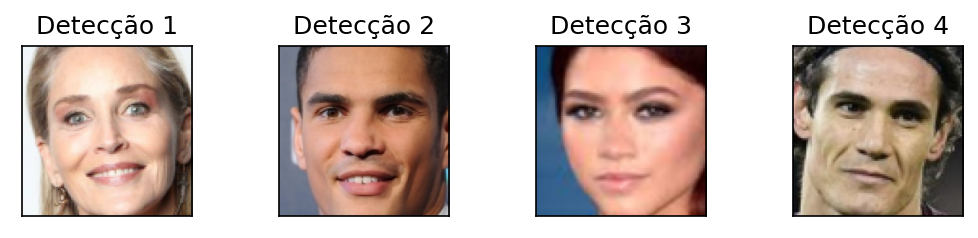

In [51]:
num_faces = faces.shape[0]
fig_luz, axes = plt.subplots(1,num_faces,figsize=(7,3), dpi = 150)
plt.tight_layout()

for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(num_faces):
    axes[i].imshow(faces[i])
    axes[i].set_title('Detecção '+ str(i+1))
plt.show()

In [52]:
samples = faces.astype('float32')

print(samples.min(), samples.max())

0.0 255.0


In [53]:
samples = preprocess_input(samples, version=2)

print(samples.min(), samples.max())

-130.0912 162.5047


Carregamento do modelo pré-treinado, predição e decodificação dos resultados de classificação.

In [54]:
#model = VGGFace(model='vgg16')
model = VGGFace(model='resnet50')

model.summary()



Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_________________________________________________________________________________

In [55]:
print('Quantidade de camadas: ', len(model.layers))

Quantidade de camadas:  176


Obetenção dos mapas de características de diferentes camadas da rede.

In [56]:
output_tensor = K.function([model.layers[0].input], [model.layers[3].output])
layer_output = output_tensor([samples])
out = np.array(layer_output)
conv1 = out[0,:]

output_tensor = K.function([model.layers[0].input], [model.layers[4].output])
layer_output = output_tensor([samples])
out = np.array(layer_output)
pool1 = out[0,:]

output_tensor = K.function([model.layers[0].input], [model.layers[172].output])
layer_output = output_tensor([samples])
out = np.array(layer_output)
conv2 = out[0,:]

Exibição das imagens de entrada e os mapas de características gerados pelo rede neural convolucional.

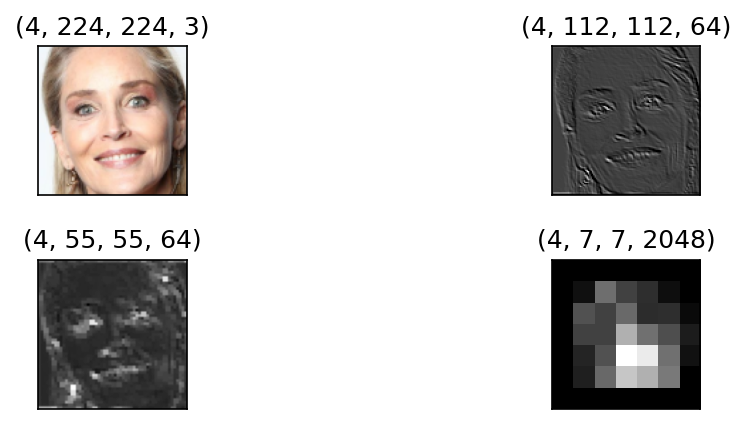

In [57]:
fig_luz, axes = plt.subplots(2,2,figsize=(7,3), dpi = 150)
plt.tight_layout()

for ax1 in range(axes.shape[0]):
    for ax2 in range(axes.shape[1]):
        axes[ax1, ax2].get_xaxis().set_visible(False)
        axes[ax1, ax2].get_yaxis().set_visible(False)

axes[0,0].imshow(faces[0])
axes[0,0].set_title(str(faces.shape))

axes[0,1].imshow(conv1[0,:,:,6], cmap='gray')
axes[0,1].set_title(str(conv1.shape))

axes[1,0].imshow(pool1[0,:,:,6], cmap='gray')
axes[1,0].set_title(str(pool1.shape))

axes[1,1].imshow(conv2[0,:,:,2], cmap='gray')
axes[1,1].set_title(str(conv2.shape))

plt.show()

Resultado de classificação das faces detectadas. Distribuição de probabilidades das 8631 celebridades presentes no dataset VGGFace2.

In [58]:
yhat = model.predict(samples)


print(yhat.shape)

(4, 8631)


In [59]:
top = 5
results = decode_predictions(yhat, top=top)

for i in range(np.size(results, axis=0)):
    
    print('\nDetecção', i+1)
    
    for result in results[i]:
        print('%s: %.3f%%' % (result[0][3:-1], result[1]*100))


Detecção 1
Sharon_Stone: 91.014%
Bo_Derek: 0.625%
Elisabeth_Shue: 0.319%
Noelle_Reno: 0.317%
Ewa_Da_Cruz: 0.192%

Detecção 2
Anthony_Ogogo: 98.418%
Carl_Medjani: 0.177%
Edinson_Cavani: 0.077%
Shelley_Hennig: 0.060%
Maxi_Biancucchi: 0.035%

Detecção 3
Zendaya: 85.919%
Qory_Sandioriva: 2.181%
Chrissie_Chau: 1.320%
Andien: 1.041%
Acha_Septriasa: 0.788%

Detecção 4
Edinson_Cavani: 98.505%
Daniel_Gimeno-Traver: 0.029%
Paul_Aguilar: 0.025%
Nadine_Angerer: 0.024%
Steven_Pienaar: 0.024%


# Parte 3: Análise dos resultados

Combinações das faces de pessoas detectadas.

In [60]:
names_list = []
for i in range(np.size(results, axis=0)):
    names_list.append(results[i][0][0][3:-1])


names_comb = list(itertools.combinations(names_list, 2))

print(names_comb)

[('Sharon_Stone', 'Anthony_Ogogo'), ('Sharon_Stone', 'Zendaya'), ('Sharon_Stone', 'Edinson_Cavani'), ('Anthony_Ogogo', 'Zendaya'), ('Anthony_Ogogo', 'Edinson_Cavani'), ('Zendaya', 'Edinson_Cavani')]


Combinações dos pontos centrais das faces detectadas.

In [61]:
points_list = []
for i in range(cxy.shape[0]):
    points_list.append(cxy[i])

points_comb = list(itertools.combinations(points_list, 2))

print(points_comb)

[(array([826., 320.]), array([111.,  79.])), (array([826., 320.]), array([489., 457.])), (array([826., 320.]), array([269., 739.])), (array([111.,  79.]), array([489., 457.])), (array([111.,  79.]), array([269., 739.])), (array([489., 457.]), array([269., 739.]))]


Distância euclidiana entre o centro das faces detectadas.

In [62]:
psize = np.size(points_comb, axis=0)

distance = np.zeros((psize))
for i in range(psize):
    distance[i] = np.linalg.norm(points_comb[i][1]-points_comb[i][0])

Dicionário com as combinações e distância entre as faces detectadas.

In [63]:
myDict = {'Combinações':names_comb,
          'Distância': distance}

In [64]:
resultDF = pd.DataFrame(myDict)
resultDF.head()

,Combinações,Distância
0,"(Sharon_Stone, Anthony_Ogogo)",754.523691
1,"(Sharon_Stone, Zendaya)",363.782902
2,"(Sharon_Stone, Edinson_Cavani)",697.000717
3,"(Anthony_Ogogo, Zendaya)",534.572727
4,"(Anthony_Ogogo, Edinson_Cavani)",678.648657


In [65]:
threshold = 500

contactDF = resultDF.loc[resultDF['Distância'] < 500]
contactDF.head()

,Combinações,Distância
1,"(Sharon_Stone, Zendaya)",363.782902
5,"(Zendaya, Edinson_Cavani)",357.664647
